In [1]:
import numpy as np
from spamm.run_spamm import spamm
from spamm.components.EmissionComponent import EmissionComponent
from spamm.analysis import plot_best_models, plot_chains
from spamm.Samples import Samples
from astropy.modeling.functional_models import Gaussian1D
#from run_el import create_el
import corner
import matplotlib.pyplot as plt

In [2]:
# Define a simple spectrum object or use an array for the spectral axis
class MockSpectrum:
    def __init__(self, spectral_axis):
        self.spectral_axis = spectral_axis
        self.flux = np.zeros_like(spectral_axis)

def v_to_a(velocity_width, central_wavelength):
    c = 299792.458  # Speed of light in km/s
    wavelength_width = central_wavelength * (velocity_width / c)
    return wavelength_width

In [3]:
def log_rebin(lam, spec, velscale=None, oversample=1, flux=False):
    """
    Logarithmically rebin a spectrum, or the first dimension of an array of
    spectra arranged as columns, while rigorously conserving the flux.
    The photons in the spectrum are simply redistributed according to a new
    grid of pixels, with logarithmic sampling in the spectral direction.

    When `flux=True` keyword is set, this program performs an exact
    integration of the original spectrum, assumed to be a step function
    constant within each pixel, onto the new logarithmically-spaced pixels.
    When `flux=False` (default) the result of the integration is divided by
    the size of each pixel to return a flux density (e.g. in erg/(s cm^2 A)).
    The output was tested to agree with the analytic solution.

    Input Parameters
    ----------------

    lam: either [lam_min, lam_max] or wavelength `lam` per spectral pixel.
        * If this has two elements, they are assumed to represent the central
          wavelength of the first and last pixels in the spectrum, which is
          assumed to have constant wavelength scale.
          log_rebin is faster with regular sampling.
        * Alternatively one can input the central wavelength of every
          spectral pixel and this allows for arbitrary irregular sampling in
          wavelength. In this case the program assumes the pixels edges are the
          midpoints of the input pixels wavelengths.

        EXAMPLE: For uniform wavelength sampling, using the values in the
        standard FITS keywords (but note that the format can be different)::

            lam = CRVAL1 + CDELT1*np.arange(NAXIS1)

    spec:
        Input spectrum or array of spectra to rebin logarithmically.
        This can be a vector `spec[npixels]` or array `spec[npixels, nspec]`.
    oversample:
        Can be used, not to degrade spectral resolution,
        especially for extended wavelength ranges and to avoid aliasing.
        Default: `oversample=1` implies same number of output pixels as input.
    velscale:
        Velocity scale in km/s per pixels. If this variable is not defined, it
        will be computed to produce the same number of output pixels as the
        input. If this variable is defined by the user it will be used to set
        the output number of pixels and wavelength scale.
    flux: bool
        `True` to preserve total flux, `False` to preserve the flux density.
        When `flux=True` the log rebinning changes the pixels flux in
        proportion to their dlam and the following command will show large
        differences between the spectral shape before and after `log_rebin`::

           plt.plot(exp(ln_lam), specNew)  # Plot log-rebinned spectrum
           plt.plot(np.linspace(lam[0], lam[1], spec.size), spec)

        By default `flux=`False` and `log_rebin` returns a flux density and
        the above two lines produce two spectra that almost perfectly overlap
        each other.

    Output Parameters
    -----------------        

    spec_new: 
        Logarithmically-rebinned spectrum flux.
     
    ln_lam: 
        Natural logarithm of the wavelength.

    velscale:
        Velocity scale per pixel in km/s.

    """
    lam, spec = np.asarray(lam, dtype=float), np.asarray(spec, dtype=float)
    assert np.all(np.diff(lam) > 0), '`lam` must be monotonically increasing'
    n = len(spec)
    assert lam.size in [2, n], "`lam` must be either a 2-elements range or a vector with the length of `spec`"

    if lam.size == 2:
        dlam = np.diff(lam)/(n - 1)             # Assume constant dlam
        lim = lam + [-0.5, 0.5]*dlam
        borders = np.linspace(*lim, n + 1)
    else:
        lim = 1.5*lam[[0, -1]] - 0.5*lam[[1, -2]]
        borders = np.hstack([lim[0], (lam[1:] + lam[:-1])/2, lim[1]])
        dlam = np.diff(borders)

    ln_lim = np.log(lim)
    c = 299792.458                          # Speed of light in km/s

    if velscale is None:
        m = int(n*oversample)               # Number of output elements
        velscale = c*np.diff(ln_lim)/m      # Only for output (eq. 8 of Cappellari 2017, MNRAS)
        velscale = velscale.item()          # Make velscale a scalar
    else:
        ln_scale = velscale/c
        m = int(np.diff(ln_lim)/ln_scale)   # Number of output pixels

    newBorders = np.exp(ln_lim[0] + velscale/c*np.arange(m + 1))

    if lam.size == 2:
        k = ((newBorders - lim[0])/dlam).clip(0, n-1).astype(int)
    else:
        k = (np.searchsorted(borders, newBorders) - 1).clip(0, n-1)

    specNew = np.add.reduceat((spec.T*dlam).T, k)[:-1]  # Do analytic integral of step function
    specNew.T[...] *= np.diff(k) > 0                    # fix for design flaw of reduceat()
    specNew.T[...] += np.diff(((newBorders - borders[k]))*spec[k].T)  # Add to 1st dimension

    if not flux:
        specNew.T[...] /= np.diff(newBorders)   # Divide 1st dimension

    # Output np.log(wavelength): natural log of geometric mean
    ln_lam = 0.5*np.log(newBorders[1:]*newBorders[:-1])

    return specNew, ln_lam, velscale

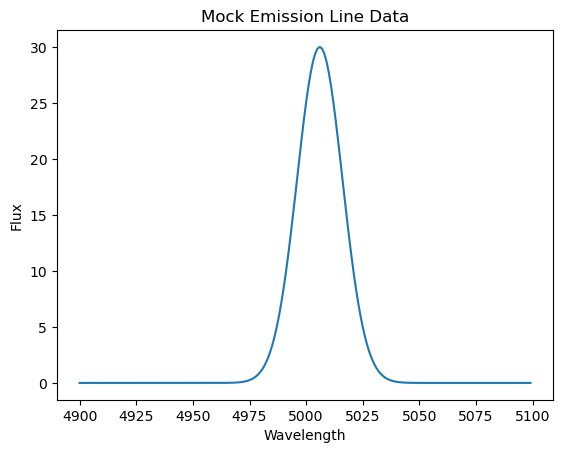

In [4]:
EL_PARAMS = {'narrow_width': 400,
             '[OIII]_5006_amp_0': 20,
             '[OIII]_5006_loc_0': 5006}

width = EL_PARAMS['narrow_width']
amp = EL_PARAMS['[OIII]_5006_amp_0']
mean = EL_PARAMS['[OIII]_5006_loc_0']

c_kms = 299792.458  # Speed of light in km/s

# Create a spectral axis
wave = np.arange(4900., 5100., 1)  # Example range

flux = 30 * np.exp(-(wave - mean)**2 / (2*v_to_a(600, mean)**2))
noise = flux*0.05

plt.plot(wave, flux)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Mock Emission Line Data')
plt.show()

In [ ]:
comp_params = {'EL': EL_PARAMS}
comp_names = {'EL'}

out = spamm(complist=['EL'], inspectrum=(wave, flux, noise), comp_params=EL_PARAMS, 
      n_walkers=30, n_iterations=5000, parallel=False,
      outdir="newtest_example", picklefile="newtest")

 26%|█████████▋                            | 1281/5000 [00:01<00:05, 695.63it/s]

In [ ]:
S = Samples("newtest_example/newtest.pickle.gz", outdir='newtest_example', burn=0)
plot_best_models(S)

In [ ]:
0.41+5.005e3

In [ ]:
flat_samples = S.model.sampler.get_chain(discard=1000, thin=1, flat=True)
fig = corner.corner(flat_samples);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = S.model.sampler.get_chain(discard=0)
#tau = S.model.sampler.get_autocorr_time()
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
axes[0].set_ylabel("width")
axes[1].set_ylabel("amplitude")
axes[2].set_ylabel("mean");